In [1]:
"""
det4363_n2_o3n2_pca
===================
Run PCA on Te-based metallicities and other properties (or emission-line
flux ratios) of the galaxies
"""

import sys, os

# from chun_codes import systime

from os.path import exists
import commands
#from astropy.io import ascii as asc
from astropy.io import fits

import numpy as np

import matplotlib.pyplot as plt
from pylab import subplots_adjust

import pylab

import astropy.units as u
import math as ma

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

from mpl_toolkits.mplot3d import Axes3D, proj3d

#draw a vector
from matplotlib.patches import FancyArrowPatch

#from astropy.table import Table

# + on 02/08/2016
# import te_repos_dict
# dict_pstyle0 = te_repos_dict.plotstyle()
# Te_rep_path0 = '/Users/cly/data/Metallicity/Others/Te_Repository/'
# sdss_dir     = '/Users/cly/data/Metallicity/Others/SDSS/'

# + on 03/08/2016
from matplotlib import lines

class Arrow3D(FancyArrowPatch):
    # + on 25/07/2016

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def cum_var(evals0, silent=True, verbose=False):
    '''
    Determines the cumulative variance percentage from the eigenvalues
    Parameters
    ----------
    evals0 : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    silent : boolean
          Turns off stdout messages. Default: True
    verbose : boolean
          Turns on additional stdout messages. Default: False
	  
    Returns
    -------
    cum_var0 : array like
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    tot      = sum(evals0)
    var0     = [(ii / tot)*100 for ii in sorted(evals0, reverse=True)]
    cum_var0 = np.cumsum(var0)

    return cum_var0
#enddef

def pca_str(evec, cum_var0=None, label_sample=None, silent=True, verbose=False):
    '''
    Construct string of PCA components to annotate plots
    Parameters
    ----------
    evec : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    cum_var0 : array like, optional
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    
    label_sample : string, optional. Default: None
      Bibliographical label for points that are plotted
    silent : boolean, optional. Default: True
          Turns off stdout messages. 
    verbose : boolean, optional. Default: False
          Turns on additional stdout messages. 
	  
    Returns
    -------
    PCA_str : string
      Raw string returned. LaTeX-formatted
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    n_vec = evec.shape[0]

    if n_vec == 2:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[0][0], evec[0][1])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[1][0], evec[1][1])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
        PCA_str  = PCA_str1+'\n'+PCA_str2
    
    if n_vec == 3:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[0][0], evec[0][1],
                                                                      evec[0][2])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[1][0], evec[1][1],
                                                                      evec[1][2])
        PCA_str3 = r'PC$_3$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[2][0], evec[2][1],
                                                                      evec[2][2])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
            PCA_str2 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[1])

        PCA_str = PCA_str1+'\n'+PCA_str2+'\n'+PCA_str3

    # Mod on 02/08/2016
    if label_sample != None:
        PCA_str = " + ".join(label_sample)+'\n'+PCA_str

    return PCA_str
#enddef

def plot_2d(x0, z0, evec, mu, sigma, labels, out_pdf=None, label_sample=None,
            ref_name0=None, cum_var0=None, silent=False, verbose=True):
    '''
    This is function to plot data in 2-D and show eigenvectors
    Parameters
    ----------
    x0 : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    z0 : array like
      Second property (y-axis), x2, e.g., 12+log(O/H)
    evec : numpy array type
      Eigenvectors for x0 and z0, shape=(2, 2)
    mu : numpy array type
      Statistical mean of x0 and z0. shape=(2,) 
    sigma : numpy array type
      Standard deviation of x0 and z0. shape=(2,)
    labels : list or numpy string array
      Labels for x and y, labels = [xlabel, ylabel]
    out_pdf : file path, file object, or file like object, optional. default: None
      Filename of output PDF file
    label_sample : string, default : None
      Label for points in legend
    silent : boolean
          Turns off stdout messages. Default: False
    verbose : boolean
          Turns on additional stdout messages. Default: True
	  
    Returns
    -------
    A PDF plot is generated
    Notes
    -----
    Created by Chun Ly, 22 July 2016
    Modified by Chun Ly, 25 July 2016
     - Added option to include cumulative variance
     - Call pca_str() to get [PCA_str]
    Modified by Chun Ly, 2 August 2016
     - out_pdf is now an option
     - Added ref_name0 as an keyword option
     - Loop over each sample/dataset
     - Use dict_pstyle0 to get plotting convention
    '''
    
    if silent == False: print '### Begin det4363_n2_o3n2_pca.plot_2d | ' #+systime()

    n_sample = len(x0)
    if silent == False: print '## n_sample : ', n_sample
    
    fig, ax = plt.subplots()

    m0 = 'o'; s0 = 25; c0 = 'b'; fc0 = 'none'; a0 = 0.5 # + on 02/08/2016

    #Mod on 02/08/2016 to loop over each sample
    for ii in range(n_sample):
        if ref_name0 != None:
            t_ref = ref_name0[ii]
            m0  = dict_pstyle0[t_ref]['m0']
            c0  = dict_pstyle0[t_ref]['c0']
            s0  = dict_pstyle0[t_ref]['s0']
            fc0 = dict_pstyle0[t_ref]['fc0']
            a0  = dict_pstyle0[t_ref]['a0'] if 'a0' in dict_pstyle0[t_ref] else 0.5

        ax.scatter(x0[ii], z0[ii], marker=m0, s=s0, c=c0, facecolor=fc0,
                   alpha=a0, label=label_sample[ii]) #, edgecolor='none')
    
    # Mod on 25/07/2016
    PCA_str = pca_str(evec, cum_var0=cum_var0)

    ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top')
    
    for axis in evec:
        start, end = mu, mu + sigma * axis
        ax.annotate('', xy=end, xycoords='data', xytext=start, textcoords='data',
                    arrowprops=dict(facecolor='red', edgecolor='red', width=2.0,
                                    alpha=0.5))
    
    ax.set_aspect('equal') # This changes the aspect ratio of plot for 1:1

    ax.legend(loc='lower right', fontsize='10', frameon=False)
        
    ax.set_xlabel(r'$x_1$ = '+labels[0], fontsize='16')
    ax.set_ylabel(r'$x_2$ = '+labels[1], fontsize='16')
    ax.minorticks_on()
    
    fig.set_size_inches(8,8)
    fig.tight_layout()
    
    # Adjust margins
    subplots_adjust(left=0.025, bottom=0.025, top=0.975, right=0.975,
                    wspace=0.03, hspace=0.03)
    
    # Write to PDF file | Mod on 02/08/2016
    if out_pdf != None:
        if silent == False: print '### Writing : ', out_pdf
        fig.savefig(out_pdf, bbox_inches='tight')
        plt.close()
        fig.clear()
    #endif
    if silent == False: print '### End det4363_n2_o3n2_pca.plot_2d | '#+systime()
#enddef

def plot_3d(x0, y0, z0, evec, mu, sigma, labels, out_pdf=None, label_sample=None,
            ref_name0=None, cum_var0=None, animate=False, silent=False,
            verbose=True, proposal=False):
    '''
    This is function to plot data in 3-D and show eigenvectors
    Parameters
    ----------
    x0 : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    y0 : array like
      Second property (y-axis), x2, e.g., log(SFR), etc.
    z0 : array like
      Third property (z-axis), x3, e.g., 12+log(O/H)
    evec : numpy array type
      Eigenvectors for x0, y0, and z0, shape=(3, 3)
    mu : numpy array type
      Statistical mean of x0, y0, and z0. shape=(3,) 
    sigma : numpy array type
      Standard deviation of x0 and z0. shape=(2,)
    labels : list or numpy string array
      Labels for x, y, and x, labels = [xlabel, x2label, zlabel]
    out_pdf : file like object, default : None
      Filename of output PDF file
    label_sample : string, default : None
      Label for points in legend
    ref_name0 : list or np.array of strings, optional. Default: None
      Abbreviated reference for sample. Used for dict definition
    animate : boolean
      Performs a 360 deg rotation on the viewing angle to matplotlib
    silent : boolean
      Turns off stdout messages. Default: False
    verbose : boolean
      Turns on additional stdout messages. Default: True
    Returns
    -------
    A PDF plot is generated
    Notes
    -----
    Created by Chun Ly, 22 July 2016
    Modified by Chun Ly, 25 July 2016
     - Added option to include cumulative variance
     - Call pca_str() to get [PCA_str]
     - Draw arrows for PC's
    Modified by Chun Ly, 2 August 2016
     - Loop over each sample/dataset
     - Use dict_pstyle0 to get plotting convention
    '''

    if silent == False:
        print '### Begin det4363_n2_o3n2_pca.plot_3d | '#+systime()

    n_sample = len(x0)
    if silent == False: print '## n_sample : ', n_sample

    fig = plt.figure() #pylab.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    m0 = 'o'; s0 = 25; c0 = 'b'; fc0 = 'none'; a0 = 0.5 # + on 02/08/2016

    #Mod on 02/08/2016 to loop over each sample
    for ii in range(n_sample):
        if ref_name0 != None:
            t_ref = ref_name0[ii]
            m0  = dict_pstyle0[t_ref]['m0']
            c0  = dict_pstyle0[t_ref]['c0']
            s0  = dict_pstyle0[t_ref]['s0']
            fc0 = dict_pstyle0[t_ref]['fc0']
            a0  = dict_pstyle0[t_ref]['a0'] if 'a0' in dict_pstyle0[t_ref] else 0.5

        #print m0, c0, s0, fc0, a0
        ax.scatter(x0[ii], y0[ii], z0[ii], marker=m0, s=s0, c=c0, edgecolors=c0,
                   label=label_sample[ii]) #alpha=1.0, 

    # Mod on 25/07/2016
    # Mod on 15/09/2016
    if proposal == False:
        PCA_str = pca_str(evec, cum_var0=cum_var0, label_sample=label_sample)
    else:
        PCA_str = pca_str(evec, cum_var0=cum_var0)
        
    ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top')

    # Overlay arrows for PC's and label them
    # + on 25/07/2016
    for ii in range(evec.shape[0]):
        axis = evec[ii]
        if silent == False: print '## axis : ', ii, axis
        xd = [mu[0], mu[0] + sigma * axis[0]]
        yd = [mu[1], mu[1] + sigma * axis[1]]
        zd = [mu[2], mu[2] + sigma * axis[2]]
        
        a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
                    color="r")
        ax.add_artist(a)

        xt = mu[0] + 1.05 * sigma * axis[0]
        yt = mu[1] + 1.05 * sigma * axis[1]
        zt = mu[2] + 1.05 * sigma * axis[2]
        ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

    #ax.set_aspect('equal')
    if proposal == False:
        ax.legend() #loc='lower right', fontsize='10', frameon=False)

    ax.set_xlabel(r'$x_1$ = '+labels[0], fontsize='12')
    ax.set_ylabel(r'$x_2$ = '+labels[1], fontsize='12')
    ax.set_zlabel(r'$x_3$ = '+labels[2], fontsize='12')

    for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
        axis.gridlines.set_linestyle('dashed')
        axis.set_pane_color((1,1,1,1)) # White background
        axis.gridlines.set_color((0,0,0,1)) # Black grid

    bottom = 0.025
    if 'beta' in labels[0]: bottom = 0.10

    # Adjust margins
    subplots_adjust(left=0.025, bottom=bottom, top=0.975, right=0.975,
                    wspace=0.03, hspace=0.03)

    if out_pdf == None and animate == True:
        for angle in range(0, 360, 2):
            ax.view_init(30, angle)
            plt.draw()        
    #endif

    #Write to PDF file
    if out_pdf != None:
        if silent == False: print '### Writing : ', out_pdf
        fig.savefig(out_pdf) #, bbox_inches='tight')
        plt.close()
        fig.clear()
    #endif

    if silent == False: print '### End det4363_n2_o3n2_pca.plot_3d | '#+systime()
#enddef

def plot_3d_proj(projected_data, evec, labels, out_pdf=None, label_sample=None,
                 ref_name0=None, animate=False, silent=False, verbose=True):
    '''
    This is function to plot 3-D data in principal component space
    Parameters
    ----------
    projected_data : numpy array like
      dot product of data with evec
    evec : numpy array type
      Eigenvectors, shape=(3,3)
    labels : string list or numpy string array
      Labels for x, y, and z
    out_pdf : file like object, default : None
      Filename of output PDF file
    label_sample : string, default : None
      Label for points in legend
    ref_name0 : list or np.array of strings, optional. Default: None
      Abbreviated reference for sample. Used for dict definition
    animate : boolean
      Performs a 360 deg rotation on the viewing angle within matplotlib
    silent : boolean
      Turns off stdout messages. Default: False
    verbose : boolean
      Turns on additional stdout messages. Default: True
    Returns
    -------
    A PDF plot is generated
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    Modified by Chun Ly, 3 August 2016
     - Handles multiple datasets
    '''

    if silent == False:
        print '### Begin det4363_n2_o3n2_pca.plot_3d_proj | '#+systime()

    n_sample = len(projected_data)
    if silent == False: print '## n_sample : ', n_sample

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    m0 = 'o'; s0 = 25; c0 = 'b'; fc0 = 'none'; a0 = 0.5 # + on 03/08/2016

    #Mod on 03/08/2016 to loop over each sample
    for ii in range(n_sample):
        if ref_name0 != None:
            t_ref = ref_name0[ii]
            m0  = dict_pstyle0[t_ref]['m0']
            c0  = dict_pstyle0[t_ref]['c0']
            s0  = dict_pstyle0[t_ref]['s0']
            fc0 = dict_pstyle0[t_ref]['fc0']
            a0  = dict_pstyle0[t_ref]['a0'] if 'a0' in dict_pstyle0[t_ref] else 0.5

        trans0 = projected_data[ii].T
        ax.scatter(trans0[0], trans0[1], trans0[2], marker=m0, s=s0, c=c0,
                   facecolor=fc0, alpha=1.0, label=label_sample[ii])

        #t_temp = lines.Line2D([0],[0], linestyle="none", c=c0, marker=m0, markersize=s0, mfc=fc0, label='blah')
        #cmd = 't_s'+str(ii)+' = t_temp'
        #print t_temp
        #exec(cmd)

    PCA_str = r'$x_1$ = '+labels[0]+'\n'+r'$x_2$ = '+labels[1]+'\n'+\
              r'$x_3$ = '+labels[2]

    if label_sample != None: PCA_str = " + ".join(label_sample)+'\n'+PCA_str
    if verbose == True: print PCA_str
    ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction', ha='left',
                va='top')

    #leg_str0 = ", ".join(['t_s'+str(a) for a in range(n_sample)])
    #cmd = "ax.legend(["+leg_str0+"], numpoints=1)" #, fontsize='10', frameon=False)"
    #print cmd
    #exec(cmd)

    txt0 = '$%+5.3fx_1 %+5.3fx_2 %+5.3fx_3$' % (evec[0][0], evec[0][1], evec[0][2])
    txt1 = '$%+5.3fx_1 %+5.3fx_2 %+5.3fx_3$' % (evec[1][0], evec[1][1], evec[1][2])
    txt2 = '$%+5.3fx_1 %+5.3fx_2 %+5.3fx_3$' % (evec[2][0], evec[2][1], evec[2][2])
    ax.set_xlabel(r'PC$_1$ = '+txt0, fontsize='12')
    ax.set_ylabel(r'PC$_2$ = '+txt1, fontsize='12')
    ax.set_zlabel(r'PC$_3$ = '+txt2, fontsize='12')

    for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
        axis.gridlines.set_linestyle('dashed')
        axis.set_pane_color((1,1,1,1)) # White background
        axis.gridlines.set_color((0,0,0,1)) # Black grid

    bottom = 0.025

    # Adjust margins
    subplots_adjust(left=0.025, bottom=bottom, top=0.975, right=0.975,
                    wspace=0.03, hspace=0.03)

    if out_pdf == None and animate == True:
        for angle in range(0, 360, 2):
            ax.view_init(30, angle)
            plt.draw()        
    #endif

    #Write to PDF file
    if out_pdf != None:
        if silent == False: print '### Writing : ', out_pdf
        fig.savefig(out_pdf) #, bbox_inches='tight')
        plt.close()
        fig.clear()
    #endif

    if silent == False:
        print '### End det4363_n2_o3n2_pca.plot_3d_proj | '#+systime()
#enddef

def main(OH_Te, ratio0, out_pdf, xlabel, label_sample=None, ref_name0=None,
         prop0=None, x2label=None, animate=False, silent=False, verbose=True,
         proposal=False):

    '''
    This is the main() function to run the PCA on a 2-D or 3-D dataset
    Parameters
    ----------
    OH_Te : list of numpy arrays
      Array of 12+log(O/H) from Te-based measurements. Each element of the list
      is a separate sample. e.g., OH_Te[0] is the first sample
    ratio0 : list of numpy arrays
      Array of log(NII/Halpha) or log(O3N2) or a PP04 transformation to
      metallicity. Each element of the list is a separate sample. e.g., OH_Te[0]
      is the first sample
    
    out_pdf : file path, file object, or file like object
      Filename of output PDF file
    xlabel : raw text for ax.set_xlim()
    label_sample : list or np.array of strings, optional. Default: None
      Bibliographical label for points that are plotted
    ref_name0 : list or np.array of strings, optional. Default: None
      Abbreviated reference for sample. Used for dict definition
    prop0 : list of numpy arrays, optional. Default: None
      Secondary parameter considered for PCA analysis
    x2label : raw text for ax.set_xlim() for [prop0], optional. Default: None
      Secondary parameter considered for PCA analysis
    
    animate : boolean
      Does viewing angle for loop to view 3-D space
    silent : boolean
      Turns off stdout messages. Default: False
    verbose : boolean
      Turns on additional stdout messages. Default: True
	  
    Returns
    -------
    Notes
    -----
    Created by Chun Ly, 21 July 2016
    Modified by Chun Ly, 25 July 2016
     - Added call to plot_3d_proj()
     - Added call to cum_var() to get cumulative variance for each PC
    Modified by Chun Ly, 2 August 2016
     - Loop over each sample/dataset and properly define lists of parameters
     - Do PCA analysis on 1-D arrays containing all datasets
    Modified by Chun Ly, 3 August 2016
     - Fix projected_data so it is a list of np.arrays similar to the input.
    '''
    
    if silent == False: print '### Begin det4363_n2_o3n2_pca.main | '#+systime()

    n_sample = len(OH_Te) # + on 02/08/2016

    # Mod on 02/08/2016
    for ii in range(n_sample):
        len0 = len(OH_Te[ii])

        if ii == 0:
            # Force as list of arrays
            xData  = [ratio0[ii]]
            zData  = [OH_Te[ii]]
            xData0 = ratio0[ii]
            zData0 = OH_Te[ii]
        else:
            xData.append(ratio0[ii])
            zData.append(OH_Te[ii])
            xData0 = np.append(xData0, ratio0[ii])
            zData0 = np.append(zData0, OH_Te[ii])
            
        if prop0 != None:
            if ii == 0:
                yData  = [prop0[ii]]
                yData0 = prop0[ii]
            else:
                yData.append(prop0[ii])
                yData0 = np.append(yData0, prop0[ii])
    #endfor

    # + on 02/08/2016
    xData0 = np.reshape(xData0, (len(xData0),1))
    zData0 = np.reshape(zData0, (len(zData0),1))
    if prop0 != None: 
        yData0 = np.reshape(yData0, (len(yData0),1))

    data = np.hstack((xData0, yData0, zData0)) if prop0 != None else \
           np.hstack((xData0, zData0))

    mu = data.mean(axis=0)
    if verbose == True: print '## mean : ', mu
    
    data = data - mu
    
    evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
    
    cum_var0 = cum_var(eval0) # + on 25/07/2016
    
    # Mod on 03/08/2016
    projected_data0 = np.dot(data, evec)
    sigma = projected_data0.std(axis=0).mean()

    # + on 03/08/2016
    if prop0 != None:
        if n_sample == 1:
            projected_data = [projected_data0]
        else:
            for ii in range(n_sample):
                x1 = np.reshape(xData[ii], (len(xData[ii]),1))
                y1 = np.reshape(yData[ii], (len(yData[ii]),1))
                z1 = np.reshape(zData[ii], (len(zData[ii]),1))
                t_data = np.hstack((x1,y1,z1))
                temp  = np.dot(t_data, evec)
                if ii == 0:
                    projected_data = [temp]
                else: projected_data.append(temp)
            #endfor
        #endelse
    #endif

    if silent == False:
        print '## evec : '
        print evec
        print '## sigma : ', sigma
        print '## eval0 : '
        print eval0
        print '## cum variance : ', cum_var0

    if prop0 == None:
        labels = [xlabel, r'$12+\log({\rm O/H})$']
        # Mod on 02/08/2016
        plot_2d(xData, zData, evec, mu, sigma, labels, out_pdf=out_pdf,
                ref_name0=ref_name0, cum_var0=cum_var0, silent=silent,
                verbose=verbose, label_sample=label_sample)
    else:
        labels = [xlabel, x2label, r'$12+\log({\rm O/H})$']
        # Mod on 02/08/2016
        plot_3d(xData, yData, zData, evec, mu, sigma, labels, out_pdf=out_pdf,
                ref_name0=ref_name0, cum_var0=cum_var0, silent=silent,
                verbose=verbose, animate=animate, label_sample=label_sample,
                proposal=proposal)

        # + on 25/07/2016
        if out_pdf != None:
            out_pdf_proj = out_pdf.replace('.pdf', '.proj.pdf')
        else:
            out_pdf_proj = None
        plot_3d_proj(projected_data, evec, labels, out_pdf=out_pdf_proj,
                     ref_name0=ref_name0, label_sample=label_sample,
                     silent=silent, verbose=verbose, animate=animate)
        
    if silent == False: print '### End det4363_n2_o3n2_pca.main | '#+systime()
#enddef

def run(ref_name0, prop_files=None, flux_files=None, out_pdf=None,
        label_sample=None, N2=False, O3N2=False, PP04=False, silent=False,
        verbose=True, LHb=False, R23=False, O3Hb=False, N2S2=False,
        N2O2=False, animate=False, proposal=False):

    '''
    Provide explanation for function here.
    Parameters
    ----------
    ref_name0 : string list or array-like
      List of abbreviated names for samples.
      E.g., ref_name0 = ['Berg2012','Izotov1994']
    prop_files : string list or array-like, optional; default: None
    flux_files : string list or array-like, optional; default: None
    silent : boolean
      Turns off stdout messages. Default: False
    verbose : boolean
      Turns on additional stdout messages. Default: True
	  
    Returns
    -------
    Notes
    -----
    Created by Chun Ly, 21 July 2016
    Modified by Chun Ly, 02 August 2016
     - Change inputs so prop_files and flux_files are optional.
     - Added ref_name0 (this is a required input)
     - Added use of dictionary to get plotting style
     - Get label_sample from dict_pstyle0
     - Added code to get filenames for [prop_files] and [flux_files]
    Modified by Chun Ly, 7 August 2016
     - Added R_23 keyword option
    Modified by Chun Ly, 9 August 2016
     - Define [w_flux] array to fix Izotov2012 galaxies without [NII]6583
       measurements
    Modified by Chun Ly, 10 August 2016
     - Added O3Hb keyword option
    Modified by Chun Ly, 15 September 2016
     - Added proposal keyword option for plotting preferences
    Modified by Chun Ly, 15 November 2016
     - Added option for PCA with N2S2 and N2O2
    '''

    if silent == False: print '### Begin det4363_n2_o3n2_pca.run | '#+systime()

    if type(ref_name0) == str: ref_name0 = [ref_name0] # + on 02/08/2016

    # Mod on 02/08/2016
    if label_sample == None:
        label_sample = []
        for t_ref in ref_name0:
            label_sample.append(dict_pstyle0[t_ref]['label'])        

    # + on 02/08/2016
    get_prop = (1 if prop_files == None else 0)
    get_flux = (1 if flux_files == None else 0)

    # Get filenames | + on 02/08/2016
    if get_prop or get_flux:
        prop_files = []; flux_files = []
        for t_ref in ref_name0:
            t_dir = (dict_pstyle0[t_ref]['dir'] if
                     'dir' in dict_pstyle0[t_ref].keys() else t_ref)

            if 'SDSS' not in t_ref:
                file1 = '%s%s/%s_Te_table.fits' % (Te_rep_path0, t_dir, t_ref)
                file2 = '%s%s/%s_sample.det4363.int.fits' % (Te_rep_path0, t_dir,
                                                             t_ref)
            else:
                file1 = sdss_dir + 'SDSS_DR7_det4363_Te_table.dered.fits'
                file2 = sdss_dir + 'SDSS_DR7_det4363_Te_table.dered.fits'

            if get_prop: prop_files.append(file1)
            if get_flux: flux_files.append(file2)

    # Moved up on 02/08/2016
    prop0   = None
    x2label = None

    # Mod on 02/08/2016 to loop
    for ii in range(len(ref_name0)):
        if silent == False:
            print '### Reading : ', prop_files[ii]
            print '### Reading : ', flux_files[ii]
            
        tab1 = fits.getdata(prop_files[ii])
        tab2 = fits.getdata(flux_files[ii])

        # Fix for Izotov2012 without NII or other fluxes | + on 09/08/2016
        if N2 == True:
            w_flux = np.where((tab2.NII_6584_FLUX != -1) &
                              (tab2.H_ALPHA_FLUX != -1))[0]
        if O3N2 == True:
            w_flux = np.where((tab2.NII_6584_FLUX != -1) &
                              (tab2.H_ALPHA_FLUX != -1) &
                              (tab2.OIII_5007_FLUX != -1) & 
                              (tab2.H_BETA_FLUX != -1))[0]

        if verbose == True: print '## w_flux : ', len(w_flux)
        tab1  = tab1[w_flux]
        tab2  = tab2[w_flux]

        # List of np arrays | Mod on 02/08/2016
        if ii == 0:
            OH_Te     = [tab1.OH_gas]
            OH_Te_err = [tab1.OH_gas_lo, tab1.OH_gas_hi]
        else:
            OH_Te.append(tab1.OH_gas)
            OH_Te_err.append([tab1.OH_gas_lo, tab1.OH_gas_hi])

        if N2 == True:
            x_temp = np.log10(tab2.NII_6584_FLUX / tab2.H_ALPHA_FLUX)
            if PP04 == True:
                xlabel = r'$8.90 + 0.57\,\log([{\rm NII}]\lambda6584/{\rm H}\alpha)$'
                #ratio0 = 9.37 + 2.03*x_temp + 1.26*x_temp**2 + 0.32*x_temp**3
                t_ratio0 = 8.90 + 0.57*x_temp
            else:
                xlabel = r'$\log([{\rm NII}]\lambda6584/{\rm H}\alpha)$'
                t_ratio0 = x_temp

        # Mod on 25/07/2016 to handle PP04=True
        if O3N2 == True:
            lO3Hb  = np.log10(tab2.OIII_5007_FLUX / tab2.H_BETA_FLUX)
            lN2Ha  = np.log10(tab2.NII_6584_FLUX / tab2.H_ALPHA_FLUX)
            x_temp = lO3Hb - lN2Ha
            if PP04 == True:
                xlabel = r'$8.73 - 0.32\,\log({\rm O3N2})$'
                t_ratio0 = 8.73 - 0.32 * x_temp
            else:
                xlabel = r'$\log\left[([{\rm O\ III}]\lambda5007/{\rm H}\beta)/([{\rm N\ II}]\lambda6583/{\rm H}\alpha)\right]$'
                t_ratio0 = x_temp

        # List of np.arrays | + on 02/08/2016
        if ii == 0:
            ratio0 = [t_ratio0]
        else: ratio0.append(t_ratio0)

        if 'z_spec' in tab2.names:
            dL = cosmo.luminosity_distance(tab2.z_spec)
        if 'D_Mpc' in tab2.names:
            dL = tab2.D_Mpc * u.Mpc

        if LHb == True:
            L_Hbeta   = (tab2.F_Hbeta * u.erg/u.s/u.cm**2) * 4* ma.pi * (dL.to(u.cm))**2
            logLHbeta = np.log10(L_Hbeta / (u.erg/u.s))
            x2label   = r'$\log({\rm L}[{\rm H}\beta]/{\rm erg\ s}^{-1})$'

            # List of np.arrays | Mod on 02/08/2016
            if ii == 0:
                prop0 = [logLHbeta.value]
            else:
                prop0.append(logLHbeta.value)

        # + on 07/08/2016
        if R23 == True:
            t_R23  = tab2.OII_3727_FLUX+tab2.OIII_4959_FLUX+tab2.OIII_5007_FLUX
            t_R23 /= tab2.H_BETA_FLUX
            logR23_value = np.log10(t_R23)
            x2label      = r'$\log(R_{23})$'
            
            if ii == 0:
                prop0 = [logR23_value]
            else:
                prop0.append(logR23_value)

        # + on 10/08/2016
        if O3Hb == True:
            t_O3Hb  = np.log10(tab2.OIII_5007_FLUX / tab2.H_BETA_FLUX)
            x2label = r'$\log([{\rm OIII}]\lambda5007/{\rm H}\beta)$'
            
            if ii == 0:
                prop0 = [t_O3Hb]
            else:
                prop0.append(t_O3Hb)

        # + on 15/11/2016
        if N2S2 == True:
            t_N2S2  = np.log10(tab2.NII_6584_FLUX /
                               (tab2.SII_6717_FLUX + tab2.SII_6731_FLUX))
            x2label = r'$\log([{\rm NII}]\lambda6584/[{\rm SII}]\lambda\lambda6717,6731)$'
            
            if ii == 0:
                prop0 = [t_N2S2]
            else:
                prop0.append(t_N2S2)
        
        # + on 15/11/2016
        if N2O2 == True:
            t_N2O2  = np.log10(tab2.NII_6584_FLUX / tab2.OII_3727_FLUX)
            x2label = r'$\log([{\rm NII}]\lambda6584/[{\rm OII}]\lambda\lambda3726,3729)$'
            
            if ii == 0:
                prop0 = [t_N2O2]
            else:
                prop0.append(t_N2O2)

        # + on 02/08/2016 | Moved lower on 07/08/2016
        # Mod on 15/11/2016
        if LHb == True or R23 == True or O3Hb == True or N2S2 == True:
            good = np.where(np.isfinite(prop0[ii]) == True)[0]
            if len(good) != len(tab2):
                prop0[ii]  = prop0[ii][good]
                OH_Te[ii]  = OH_Te[ii][good]
                ratio0[ii] = ratio0[ii][good]
            #endif
        #endif
    #endfor

    # Mod on 02/08/2016
    main(OH_Te, ratio0, out_pdf, xlabel, label_sample=label_sample,
         ref_name0=ref_name0, prop0=prop0, x2label=x2label, silent=silent,
         verbose=verbose, animate=animate, proposal=proposal)
        
    if silent == False: print '### End det4363_n2_o3n2_pca.run | '#+systime()

#enddef


In [2]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

%matplotlib inline
# %matplotlib qt
%matplotlib notebook

In [21]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])


# defining useful data structs for plotting
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
markarr = np.array(['o', 'o', '^', 'D', '*'])

# defining an approximate redshift array for plot visualization
z_arr0 = np.array([7046.0, 7111.0, 8150.0, 9196.0, 9755.0])/6563.0 - 1
z_arr0 = np.around(z_arr0, 2)
z_arr  = np.array(z_arr0, dtype='|S4')
z_arr  = np.array([x+'0' if len(x)==3 else x for x in z_arr])

# defining a flux sigma cutoff
good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]

# title = 'mainseq_filt_nii_dust_corrs'
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

xarr = stlr_mass[good_sig_iis]
yarr = obs_sfr[good_sig_iis]+corrs[good_sig_iis]
zarr = zspec0[good_sig_iis]

ffs = filts[good_sig_iis]

In [22]:
badz_iis = np.array([x for x in range(len(zarr)) if zarr[x] < 0 or zarr[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

In [23]:
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zarr[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1

In [24]:
xData = np.copy(xarr)
yData = np.copy(yarr)
zData = np.copy(zarr)

n_sample = len(xData)

In [25]:
xData0 = np.reshape(xData, (len(xData),1))
yData0 = np.reshape(yData, (len(yData),1))
zData0 = np.reshape(zData, (len(zData),1))

In [26]:
data = np.hstack((xData0, yData0, zData0))

In [27]:
mu = data.mean(axis=0)
print '## mean : ', mu

## mean :  [ 8.08473881 -1.23577965  0.33330504]


In [28]:
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

In [29]:
for ii in range(n_sample):
    x1 = np.reshape(xData[ii], (len(xData[ii]),1))
    y1 = np.reshape(yData[ii], (len(yData[ii]),1))
    z1 = np.reshape(zData[ii], (len(zData[ii]),1))
    t_data = np.hstack((x1,y1,z1))
    temp  = np.dot(t_data, evec)
    if ii == 0:
        projected_data = [temp]
    else: projected_data.append(temp)


TypeError: object of type 'numpy.float64' has no len()

In [30]:
labels = ['M', 'SFR', 'z']

In [31]:
# plot_3d(xData, yData, zData, evec, mu, sigma, labels, out_pdf='temp_out.pdf',
#         ref_name0=None, cum_var0=cum_var0, silent=False,
#         verbose=True, animate=False, label_sample=None,
#         proposal=False)

In [33]:
evec

array([[-0.73650879,  0.67625642,  0.01523336],
       [-0.67140887, -0.72812015, -0.13802602],
       [-0.08224927, -0.11188519,  0.99031145]])

In [35]:
cum_var0

array([  75.5222654 ,   95.57720212,  100.        ])

<IPython.core.display.Javascript object>


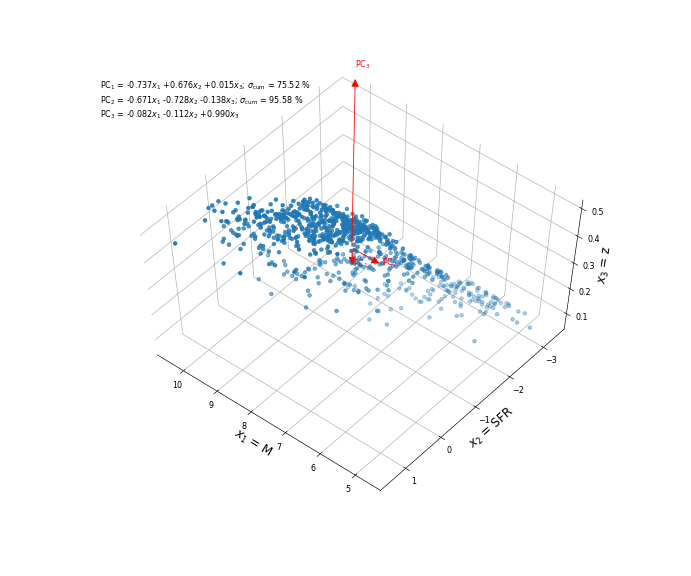

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:131: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [45]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.set_size_inches(12,10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xarr, yarr, zarr)
ax.set_xlabel(r'$x_1$ = '+labels[0], fontsize='15')
ax.set_ylabel(r'$x_2$ = '+labels[1], fontsize='15')
ax.set_zlabel(r'$x_3$ = '+labels[2], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
    zd = [mu[2], mu[2] + sigma * axis[2]]

    a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
                color="r")
    ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
    zt = mu[2] + 1.05 * sigma * axis[2]
    ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top')


for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.gridlines.set_linestyle('dashed')
    axis.set_pane_color((1,1,1,1)) # White background
    axis.gridlines.set_color((0,0,0,1)) # Black grid